# Example documentation
Below is (some) of the structure of this repository. What is excluded is not directly important to this example documentation
```
.
├── main.ipynb
└── src
    ├── analysis_tools.py
    ├── data_interface.py
    ├── data_parser.py
    ├── error_definitions.py
    └── run_info
        ├── ibex_coremark.ini
        ├── run_info.py
        └── sections.py
```
## Run info
In the `run_info` directory there are 3 files. The file `ibex_coremark.ini` file is the configuration of a given type of run on some given hardware (in this case the ibex soc, with coremark running). This file should function as a template for other configurations. There are 4 sections in the config:
- `DATA`
  - Every field in this section MUST be filled, and point to a valid directory / file (except timeout, which is only used if you want to only read logs for some max amount of time).
- `DEBUG`
  - Every field in this section MUST be filled, and be either 0 or 1.
  - Debugging for different parts of the parsing can be turned on. If you are brave enough you can also add debugging options rather easily to other parts of the code
- `COMPARISON_DATA`
  - This section is used to define what data should be pulled from the logs.
  - The data specified in this section must be present in a full seu run (where the logs aren't cut off early), and the golden run.
  - If a line in this section is e.g. `matrix_crc=[0]crcmatrix` the tool will create a variable in python called `matrix_crc` (on the run_info object). The data-parser will then find the first line in the log matching `[0]crcmatrix`. The parser will split this line by the string `[0]crcmatrix`, and take the second entry (if the string `[0]crcmatrix` appears multiple times only this second entry in the split line will be saved).
  - This parsed value will then be stored.
- `SEU_METADATA`
  - This section is for defining data unique to the seu runs, which we want to save.
  - The parsing and saving is done by the same method as in `COMPARISON_DATA`
  - There MUST be an entry in this section called `register` which defines where we inject on the chip. If this line is not defined the tool will not run.

The `sections.py` file defines behavior for each of the sections defined above. The `run_info.py` collects these sections into an object which can be used in the analysis tools, and by the user to check run configurations.

The `RunInfo` object should only really be interacted with for debugging purposes (making sure the `register` match string is correct for example)

## Data Interface
The data interface is the object the user should be interacting with.

It holds the `seu_log` and `golden_log` objects which will be needed to do analysis. It also holds a reference to the root of the register tree.

### Register tree
The register tree is created from the vpi register list (pointed at by the `vpi` entry in the `[DATA]` section).

The register tree is a hierarchy of the different elements in the chip. The root corresponds to the highest level of the chip, and has all components of the chip as children.

A given node represents a part (e.g. register or ip block) of the chip. We use these nodes to query the seu_log for data that is within that branch of the tree.

### seu_log and golden_log
The seu_log object is an instance of the seu_log class. This class is a wrapper around the standard pandas dataframe, extended with a name attribute (mainly used in plotting and such).

The golden log holds the information we got from the golden run, which we use for comparison against the seu runs.

## Analysis tools
more docs to follow

In [1]:
from src import DataInterface, RunInfo, BaseTools

### Showcasing the runinfo object
again, direct interaction is only useful in debugging

In [2]:
runinfo = RunInfo("src/run_info/ibex_coremark.ini")

print(runinfo.comparison_data.entries)
print(runinfo.comparison_data.matrix_crc)
print(runinfo.debug.percent_failed_reads)

['seed_crc', 'list_crc', 'matrix_crc', 'state_crc', 'final_crc']
[0]crcmatrix
True


### Instantiating via the runinfo object
the data_interface is generated by passing the runinfo object, created by the config file.

This is where much of the debugging is happening as of now

In [3]:
data_interface = DataInterface(runinfo)

Parsin SEU logs...
  Could not read /home/anders/Git/Ibex-Analysis/data/seu_2023-09-15_08-24-25.058795/log.txt
  'utf-8' codec can't decode byte 0xcc in position 5835: invalid continuation byte
  Could not read /home/anders/Git/Ibex-Analysis/data/seu_2023-09-12_23-41-25.090640/log.txt
  'utf-8' codec can't decode byte 0xcc in position 6110: invalid continuation byte
  Could not read /home/anders/Git/Ibex-Analysis/data/seu_2023-09-12_22-05-06.376439/log.txt
  'utf-8' codec can't decode byte 0xcc in position 6483: invalid continuation byte


  Could not read /home/anders/Git/Ibex-Analysis/data/seu_2023-09-18_12-37-30.570476/log.txt
  'utf-8' codec can't decode byte 0xcc in position 5742: invalid continuation byte
  Could not read /home/anders/Git/Ibex-Analysis/data/seu_2023-09-17_15-09-31.286638/log.txt
  'utf-8' codec can't decode byte 0xcc in position 5835: invalid continuation byte
  Could not read /home/anders/Git/Ibex-Analysis/data/seu_2023-09-16_18-42-29.461108/log.txt
  'utf-8' codec can't decode byte 0xc0 in position 6040: invalid start byte
  Could not read /home/anders/Git/Ibex-Analysis/data/seu_2023-09-12_03-37-48.758019/log.txt
  'utf-8' codec can't decode byte 0xc0 in position 6838: invalid start byte
  Could not read /home/anders/Git/Ibex-Analysis/data/seu_2023-09-18_17-51-15.194228/log.txt
  'utf-8' codec can't decode byte 0xcc in position 6110: invalid continuation byte
  Could not read /home/anders/Git/Ibex-Analysis/data/seu_2023-09-12_05-41-15.224915/log.txt
  'utf-8' codec can't decode byte 0x86 in posit

### Interfacing with the data

Suppose we're interested in the register_file, and we want to compare its performance with the rest of the SoC

In [4]:
path = "ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top."
path += "u_ibex_top.gen_regfile_ff.register_file_i"

node = data_interface.get_node_by_path(path)

We can also get nodes by name. Just be aware that the name search returns all possible matches, and therefore might require manual inspection

In [5]:
name = "register_file_i"
nodes = data_interface.get_node_by_name(name)
print(f"{len(nodes)} node(s) found by name")

name_node = nodes[0]

print(f"Node by name: {name_node.soc_path}\nNode by path: {node.soc_path}")

1 node(s) found by name
Node by name: ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibex_top.gen_regfile_ff.register_file_i
Node by path: ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibex_top.gen_regfile_ff.register_file_i


When we want to get data we query the interface with the node, to get the data that is relevant to that node

In [6]:
node_data = data_interface.get_data_by_node(node)
root_data = data_interface.get_data_by_node(data_interface.root)

print(f"Number of entries on node_data: {len(node_data)}")
print(f"Number of entries on root_data: {len(root_data)}")

node_data.head()

Number of entries on node_data: 6007
Number of entries on root_data: 31991


,register,injection_cycle,bit_number,value_before,value_after,seed_crc,list_crc,matrix_crc,state_crc,final_crc
seu_2023-09-11_23-14-43.659698,ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibe...,233290,23,8203f6d0,8283f6d0,NaN,NaN,NaN,NaN,NaN
seu_2023-09-12_03-15-40.606839,ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibe...,17369.9,5,00000000,00000020,: 0xe9f5,: 0xe714,: 0x1fd7,: 0x8e3a,: 0xe714
seu_2023-09-12_07-08-35.094762,ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibe...,272170,27,8203fb34,8a03fb34,: 0xe9f5,: 0x1fec,: 0x1fd7,: 0x8e3a,: 0x1fec
seu_2023-09-14_15-51-06.031115,ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibe...,280054,12,00000021,00001021,NaN,NaN,NaN,NaN,NaN
seu_2023-09-16_04-49-26.624457,ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibe...,159718,24,8203fb8e,8303fb8e,NaN,NaN,NaN,NaN,NaN


### Running an analysis
Right now only the simple classification is done, but more will be added.

Classification is standardized by the `error_definitions.py` file

In [7]:
from src import SilentError, DataCorruptionError, CriticalError

print(SilentError())
print()
print(DataCorruptionError())
print()
print(CriticalError())

Silent Error (blue)
Logs where we can't tell the difference from the golden run, using [COMPARISON_DATA] from the .ini

Data Corruption Error (orange)
Logs with different values to the golden log are considered data corruption errors

Critical Error (red)
Logs with missing information are considered critical errors. (NaN in the seu_log dataframe)


/home/anders/Git/Ibex-Analysis/src/analysis/base_tools.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/anders/Git/Ibex-Analysis/src/analysis/base_tools.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


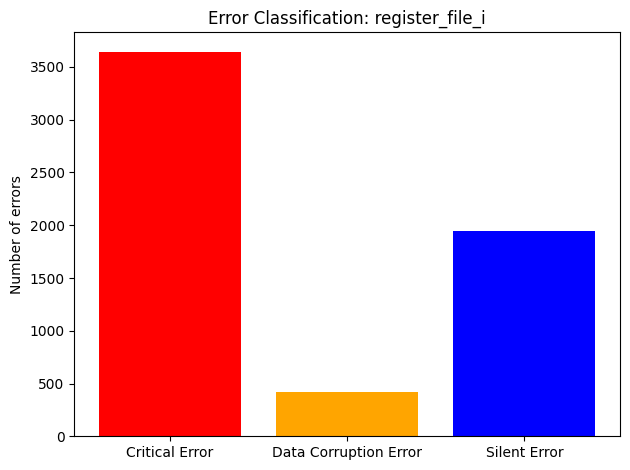

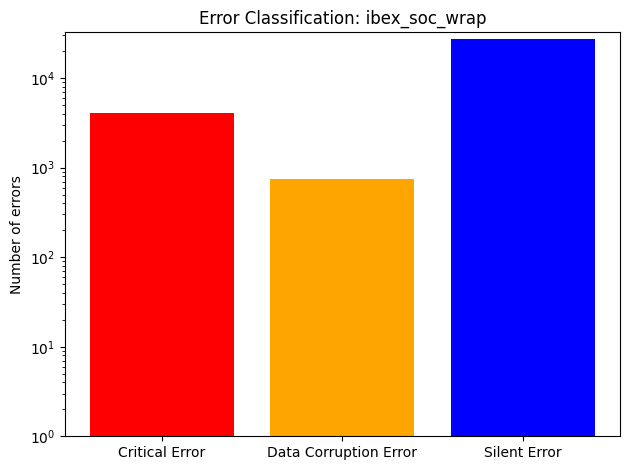

In [8]:
node_classifications, node_fig = BaseTools.error_classification(
    node_data, data_interface.golden_log, True
)
root_classifications, root_fig = BaseTools.error_classification(
    root_data, data_interface.golden_log, True
)

In [9]:
node_classifications.head()

seu_2023-09-11_23-14-43.659698           Critical Error
seu_2023-09-12_03-15-40.606839             Silent Error
seu_2023-09-12_07-08-35.094762    Data Corruption Error
seu_2023-09-14_15-51-06.031115           Critical Error
seu_2023-09-16_04-49-26.624457           Critical Error
dtype: object